# U-Net++ prediction notebook

In [1]:
import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join('../..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn

METAINFO = {
    "classes": (
        "unlabelled", "asphalt/concrete", "dirt", "mud", "water", "gravel",
        "other-terrain", "tree-trunk", "tree-foliage", "bush/shrub", "fence",
        "other-structure", "pole", "vehicle", "rock", "log", "other-object",
        "sky", "grass",
    ),
    "palette": [
        (0, 0, 0), (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200),
        (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60),
        (250, 190, 190), (0, 128, 128), (170, 110, 40), (255, 250, 200),
        (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180),
        (0, 0, 128), (128, 128, 128),
    ],
    "cidx": list(range(19))
}

## 1. Architecture

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.05):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x):
        return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes, deep_supervision=True, dropout_prob=0.05):
        super(UNetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = ConvBlock(3, nb_filter[0], dropout_prob)
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1], dropout_prob)
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2], dropout_prob)
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3], dropout_prob)
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4], dropout_prob)

        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1], dropout_prob)
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2], dropout_prob)
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3], dropout_prob)

        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], dropout_prob)
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], dropout_prob)

        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], dropout_prob)

        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], dropout_prob)

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            output = self.final(x0_4)
            return output


## 2. Data

In [4]:
def load_and_sample_data(file_path, sample_fraction=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

# Example image path
test_df = load_and_sample_data('../../dataset/test.csv')

class WildScene(Dataset):
    def __init__(self, df, img_size, num_classes, transform=None):
        self.df = df
        self.img_size = img_size
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread('../../' + row['im_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        
        label = cv2.imread('../../' + row['label_path'], cv2.IMREAD_GRAYSCALE)
        label = cv2.resize(label, (self.img_size, self.img_size))
        
        if self.transform:
            img = self.transform(img)
        
        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        label = torch.from_numpy(label).long()
        
        return img, label


def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image


def visualize_prediction(image, label, prediction, palette):
    image = image.cpu().numpy().transpose((1, 2, 0))
    label = label.cpu().numpy()
    prediction = prediction.cpu().numpy()

    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(label_to_rgb(label, palette))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(label_to_rgb(prediction, palette))
    plt.title("Prediction")
    plt.axis('off')
    plt.show()

test_dataset = WildScene(test_df, 512, 19)
test_loader = DataLoader(test_dataset, batch_size=8)

model_path = 'unetplusplus_best_model.pth'
# Initialize the model
num_classes = 19
model = UNetPlusPlus(num_classes=num_classes, deep_supervision=True).cuda()
test_df.head(16)

,id,im_path,label_path
282,1624325302-559387845,WildScenes2d/K-01/image/1624325302-559387845.png,WildScenes2d/K-01/indexLabel/1624325302-559387...
2014,1639441921-741356347,WildScenes2d/K-03/image/1639441921-741356347.png,WildScenes2d/K-03/indexLabel/1639441921-741356...
1719,1639436832-234451334,WildScenes2d/K-03/image/1639436832-234451334.png,WildScenes2d/K-03/indexLabel/1639436832-234451...
994,1639697407-429941934,WildScenes2d/V-03/image/1639697407-429941934.png,WildScenes2d/V-03/indexLabel/1639697407-429941...
2033,1624327448-585153604,WildScenes2d/K-01/image/1624327448-585153604.png,WildScenes2d/K-01/indexLabel/1624327448-585153...
297,1624326840-689300708,WildScenes2d/K-01/image/1624326840-689300708.png,WildScenes2d/K-01/indexLabel/1624326840-689300...
2051,1624329205-207176850,WildScenes2d/K-01/image/1624329205-207176850.png,WildScenes2d/K-01/indexLabel/1624329205-207176...
1590,1639435361-937405751,WildScenes2d/K-03/image/1639435361-937405751.png,WildScenes2d/K-03/indexLabel/1639435361-937405...
70,1623371058-264429850,WildScenes2d/V-02/image/1623371058-264429850.png,WildScenes2d/V-02/indexLabel/1623371058-264429...
290,1624326833-855256708,WildScenes2d/K-01/image/1624326833-855256708.png,WildScenes2d/K-01/indexLabel/1624326833-855256...


## 3. Prediction visualization

C:\Users\thedu\AppData\Local\Temp\ipykernel_43616\496312329.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


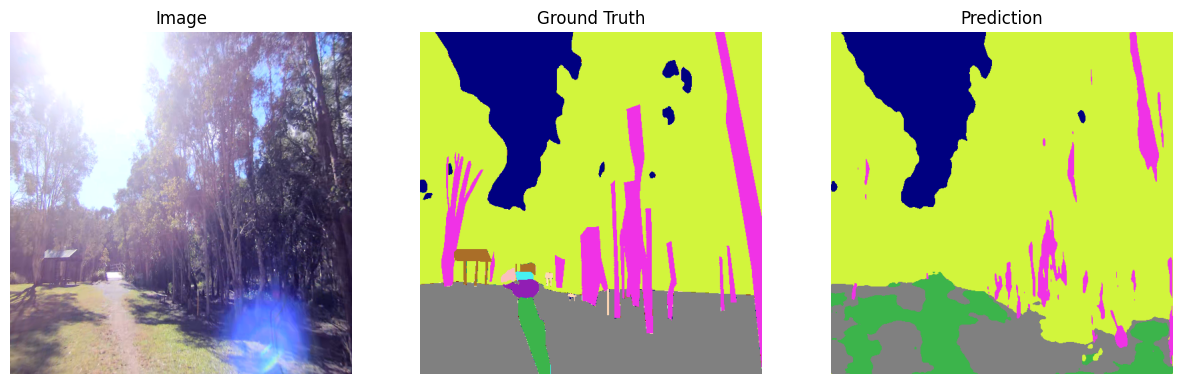

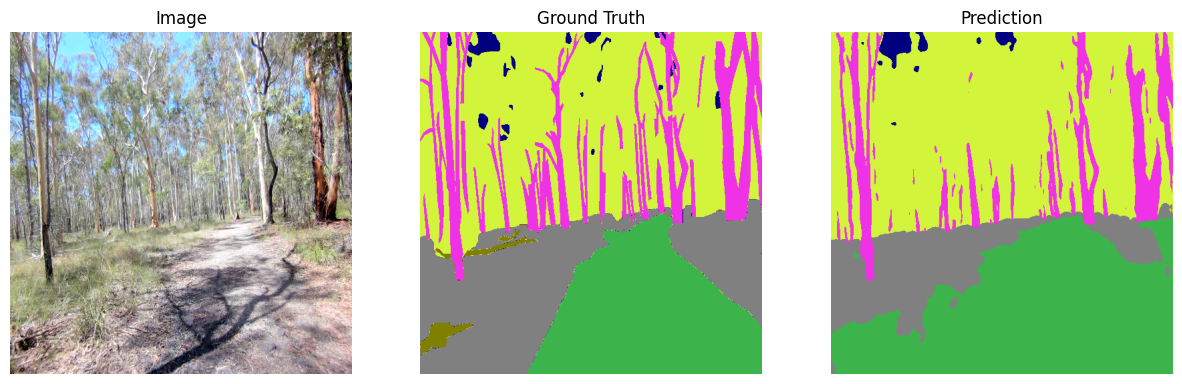

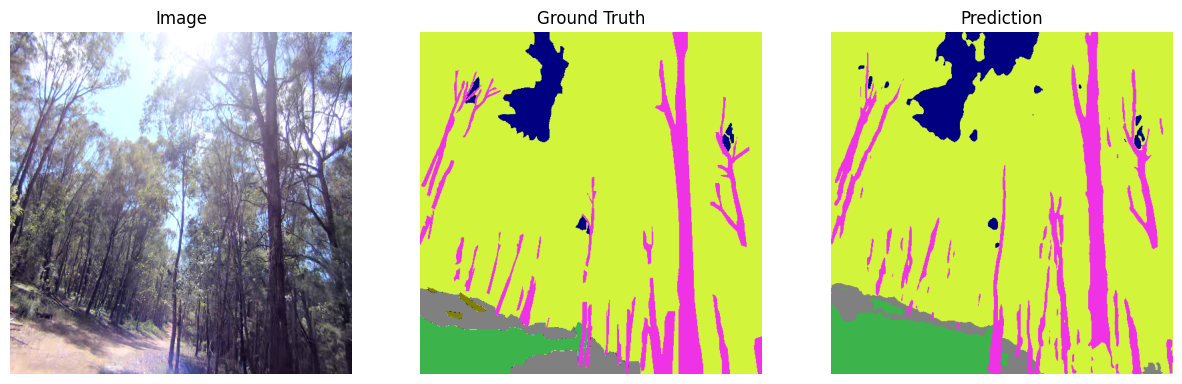

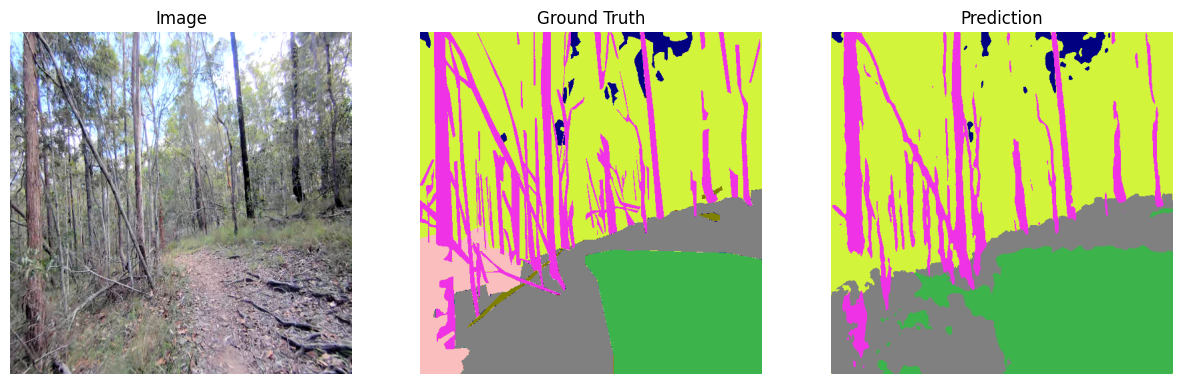

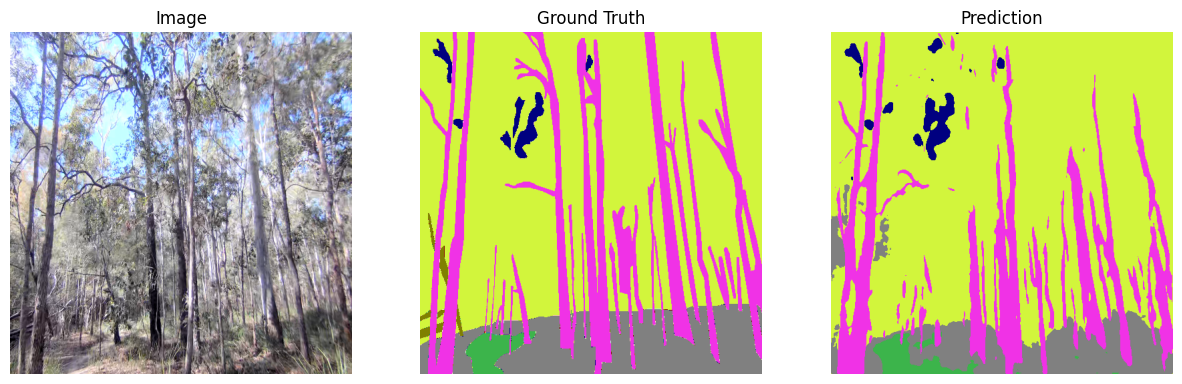

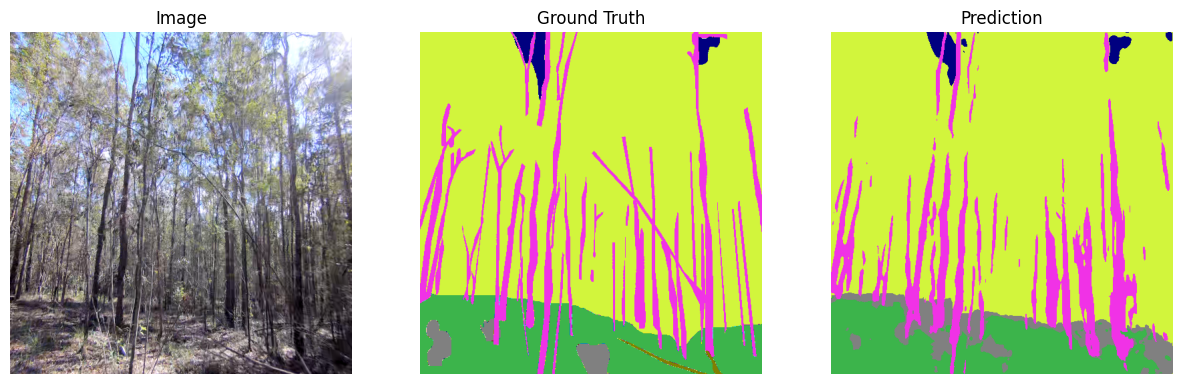

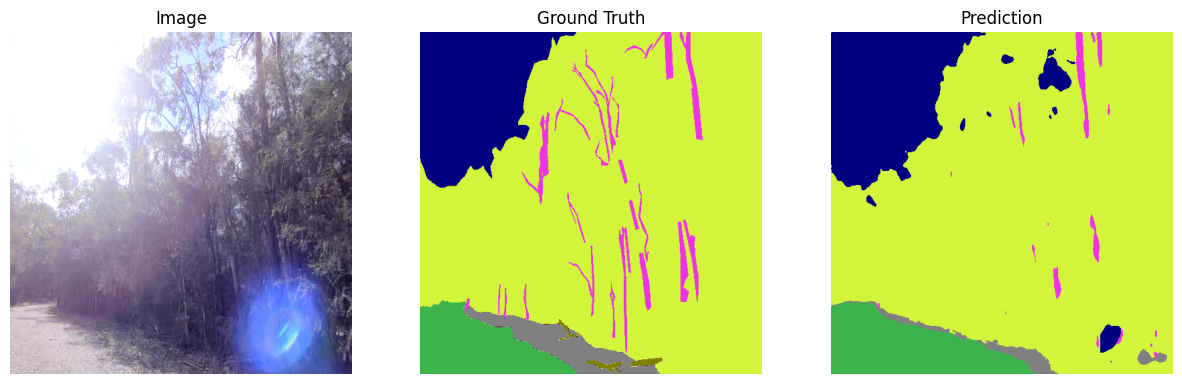

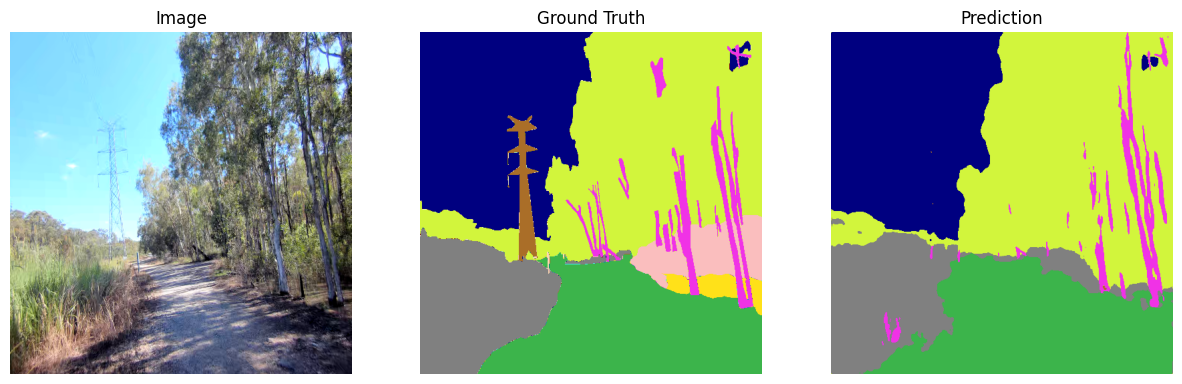

In [25]:
model_path = '../../models/unetpp/weights/unetpp_best.pth'
model.load_state_dict(torch.load(model_path))

model.eval()
with torch.no_grad():
    for data in test_loader:
        if data is None:
            continue
        
        images, labels = data
        images = images.cuda()

        outputs = model(images)
        if isinstance(outputs, list):
            outputs = outputs[-1]

        outputs = outputs.argmax(1).cpu()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            prediction = outputs[i]
            visualize_prediction(image, label, prediction, METAINFO['palette'])
        break

## 4. Prediction MIoU

In [27]:
def calculate_class_iou(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        true_class = (y_true == cls)
        pred_class = (y_pred == cls)

        intersection = (true_class & pred_class).sum().item()
        union = (true_class | pred_class).sum().item()

        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union

        ious.append(iou)

    return ious

# Define function to evaluate the model
def evaluate_model(model, test_loader, classes):
    model.eval()
    class_ious = {cls: 0 for cls in classes}
    merged_classes = []
    merged_ious = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            
            # If model outputs a list, take the last element
            if isinstance(outputs, list):
                outputs = outputs[-1]
                
            preds = torch.argmax(outputs, dim=1)

            for pred, label in zip(preds, labels):
                pred = pred.cpu().numpy().flatten()
                label = label.cpu().numpy().flatten()

                for class_idx in np.unique(label):
                    if class_idx in np.unique(pred):
                        iou = calculate_class_iou(label, pred, len(classes))[class_idx]
                        class_ious[classes[class_idx]] += iou

    for class_name in classes:
        if class_name == "pole":
            other_object_idx = classes.index("other-object")
            class_ious[classes[other_object_idx]] += class_ious[class_name]
        elif class_name == "asphalt/concrete":
            other_terrain_idx = classes.index("other-terrain")
            class_ious[classes[other_terrain_idx]] += class_ious[class_name]
        elif class_name not in ["vehicle", "pole", "asphalt/concrete", "unlabelled"]:
            merged_classes.append(class_name)
            merged_ious.append(class_ious[class_name])

    merged_class_ious = dict(zip(merged_classes, merged_ious))
    return merged_class_ious

# Evaluate the model
classes = METAINFO['classes']
merged_class_ious = evaluate_model(model, test_loader, classes)

# Print IoU results
print("\nClass-wise IoU:")
total_iou = 0
for class_name, iou in sorted(merged_class_ious.items()):
    total_iou += iou / len(test_loader.dataset) * 100
    print(f"Class {class_name:<20} IoU: {iou / len(test_loader.dataset) * 100:.4f}")

# Calculate Mean IoU
mean_iou = total_iou / 15
print(f"\nMean IoU: {mean_iou:.4f}")

Testing: 100%|███████████████████████████████████████████████████████████████████████| 267/267 [20:05<00:00,  4.51s/it]


Class-wise IoU:
Class bush/shrub           IoU: 0.0198
Class dirt                 IoU: 55.6214
Class fence                IoU: 0.0000
Class grass                IoU: 47.5016
Class gravel               IoU: 0.0016
Class log                  IoU: 0.0036
Class mud                  IoU: 0.0000
Class other-object         IoU: 0.1765
Class other-structure      IoU: 0.3250
Class other-terrain        IoU: 0.0000
Class rock                 IoU: 0.0000
Class sky                  IoU: 53.8354
Class tree-foliage         IoU: 82.6175
Class tree-trunk           IoU: 47.5704
Class water                IoU: 0.0000

Mean IoU: 19.1782
